In [32]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [33]:
api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
tags = ['2024-04-26-15-30-10', '2024-04-25-19-54-41', '2024-04-25-21-23-45', '2024-04-26-09-48-53','2024-04-26-11-22-32', '2024-05-01-11-32-26']
filters = {"tags": {"$in": tags}, "state": "finished", "config.use_visit_count": True}
runs = api.runs(entity + "/" + project, filters=filters)
runs


<Runs ajzero/AlphaZero>

In [34]:
data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

# filter out runs with Evaluation/Mean_Returns == -100
df = df[df['Evaluation/Mean_Returns'] != -100]

ncols, nrows = df["ncols"][0], 6
df

100%|██████████| 120/120 [00:01<00:00, 83.88it/s]


,Training/Regularization_loss,Self_Play/Min_Return,Evaluation/Mean_Entropy,Evaluation/Entropies,Self_Play/Min_Timesteps,Self_Play/Mean_Return,Training/Replay_Buffer_Size,grad_steps,environment_steps,Self_Play/EMA_Discounted_Return,...,policy_loss_weight,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform
0,148.038513,-13,2.590821e-07,"{'_type': 'histogram', 'bins': [-0.49999973177...",13,-13.000000,90,116,8798,-13.349960,...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity
1,156.124130,-27,3.122809e-01,"{'bins': [-0.18771907687187195, -0.17209407687...",17,-21.833334,90,116,9647,-19.631951,...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
2,161.886520,-29,3.245102e-01,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",19,-22.333334,90,116,12111,-25.568325,...,0.3,4,identity,coordinate,0.000001,PUCT,6,visit,15,identity
3,171.313354,-13,9.558185e-06,"{'_type': 'histogram', 'bins': [-0.49999043345...",13,-13.000000,90,116,9050,-13.404170,...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity
4,157.913986,-23,2.635206e-01,"{'_type': 'histogram', 'bins': [-0.23647940158...",17,-20.000000,90,116,11415,-21.865825,...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,170.487350,-19,2.437734e-01,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...",15,-16.166666,90,116,11674,-18.504281,...,0.3,4,identity,coordinate,0.000001,PUCT,6,mvc,15,identity
116,183.817841,-256,4.993233e-01,"{'bins': [-0.0006766617298126221, 0.0149483382...",19,-81.666664,90,116,12674,-51.389434,...,0.3,4,identity,coordinate,0.000001,PUCT,6,visit,15,identity
117,170.016891,-397,5.761422e-01,"{'_type': 'histogram', 'values': [0, 0, 0, 0, ...",36,-132.666672,90,116,15365,-102.163155,...,0.3,4,identity,coordinate,0.000001,PUCT,6,visit,15,identity
118,154.736176,-13,3.292095e-02,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",13,-13.000000,90,116,7653,-13.205450,...,0.3,4,identity,coordinate,0.000001,PolicyPUCT,6,mvc,15,identity


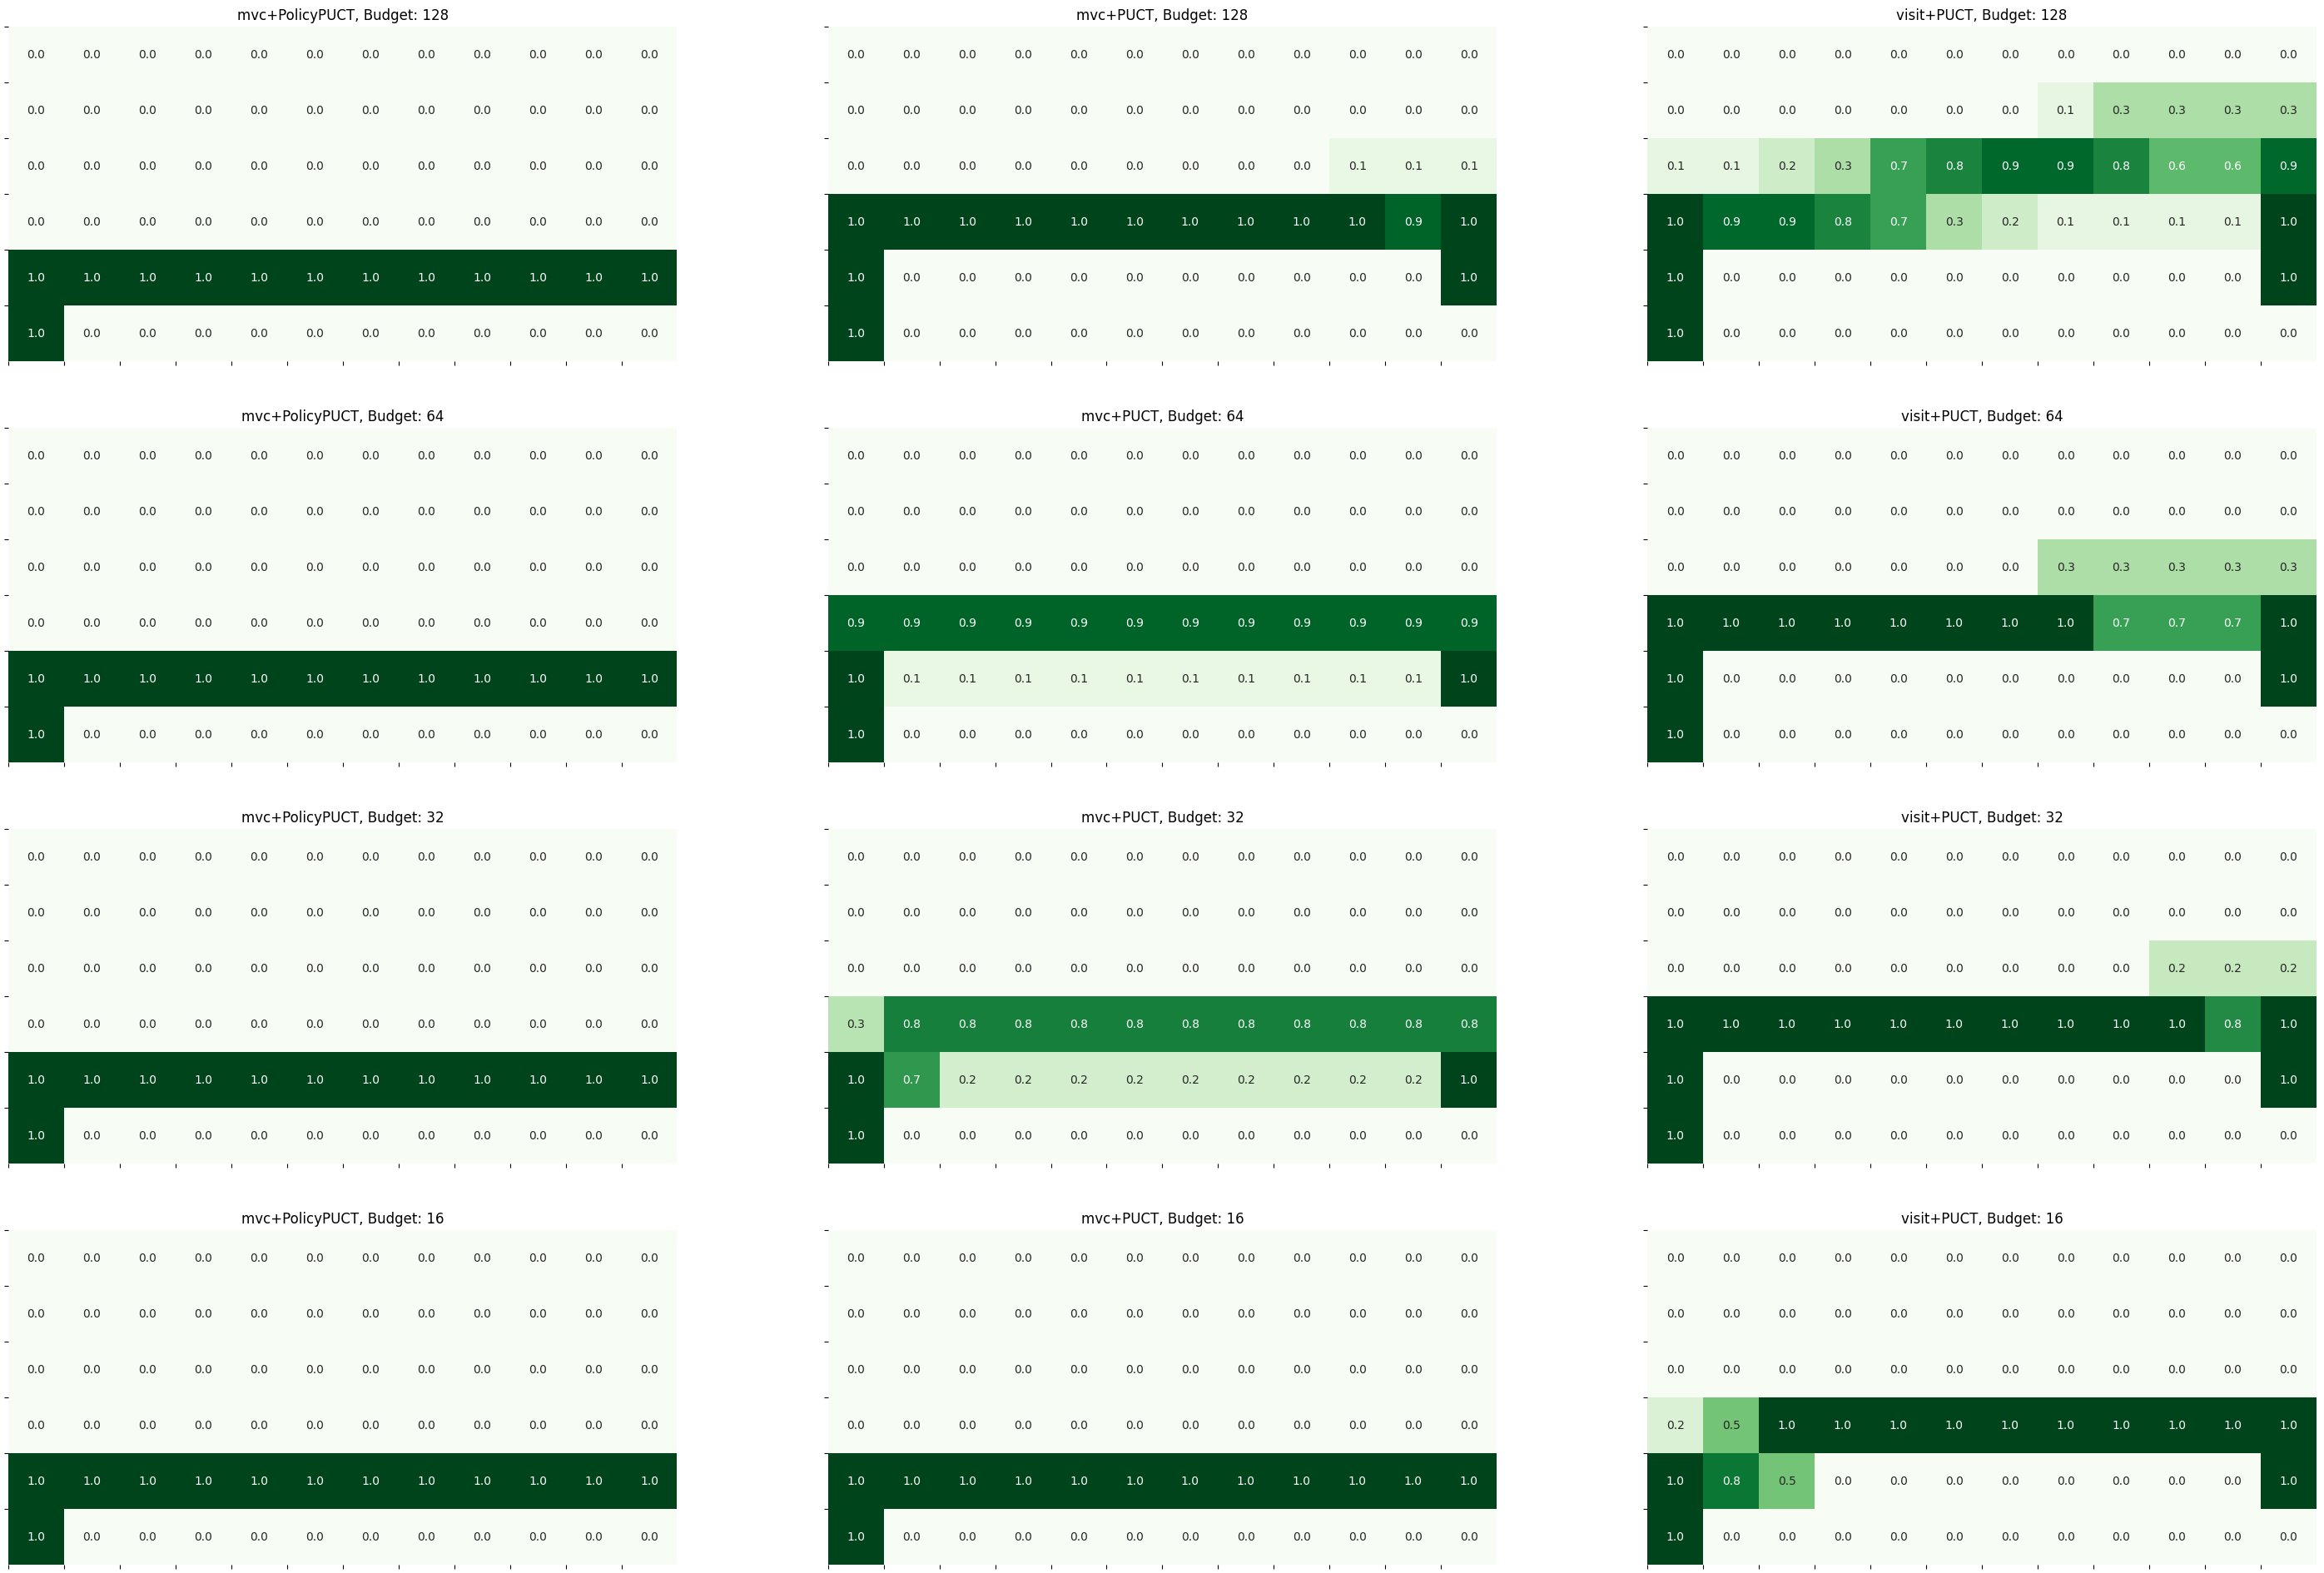

In [35]:
# filter out 128 planning budget
# Assuming 'df' is your DataFrame
df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

# Group the DataFrame by both 'policy_combination' and 'planning_budget'
grouped = df.groupby(['policy_combination', 'planning_budget'])['Evaluation/Trajectories']


# Aggregate the trajectories lists within each group
aggregated_trajectories = grouped.sum()

# Define functions to calculate coordinates and density
def obs_to_cords(state, ncols):
    row, col = divmod(state, ncols)
    return row, col

def calculate_density(trajectories, ncols, nrows):
    density = np.zeros((nrows, ncols))
    for trajectory in trajectories:
        for state in trajectory:
            row, col = obs_to_cords(state, ncols)
            density[row, col] += 1
    return density

# Determine the number of unique policy combinations and planning budgets
n_policies = len(df['policy_combination'].unique())
n_budgets = len(df['planning_budget'].unique())

# Prepare the plot
fig, axs = plt.subplots(n_budgets, n_policies, figsize=(ncols * n_policies, nrows * n_budgets))

# Plot each subgroup
for (policy_combination, planning_budget), trajectories in aggregated_trajectories.items():
    i = df['planning_budget'].unique().tolist().index(planning_budget)
    j = df['policy_combination'].unique().tolist().index(policy_combination)
    density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
    ax = axs[i][j] if n_budgets > 1 and n_policies > 1 else axs[max(i, j)]
    sns.heatmap(density, ax=ax, cmap='Greens', cbar=False, annot=True, fmt='.1f')
    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_aspect('equal')  # Set aspect ratio to be equal, making each cell square
    # set subtitle
    ax.set_title(f"{policy_combination}, Budget: {planning_budget}")




plt.savefig("outfiles/128_dist_training_cliff.pdf")
plt.show()


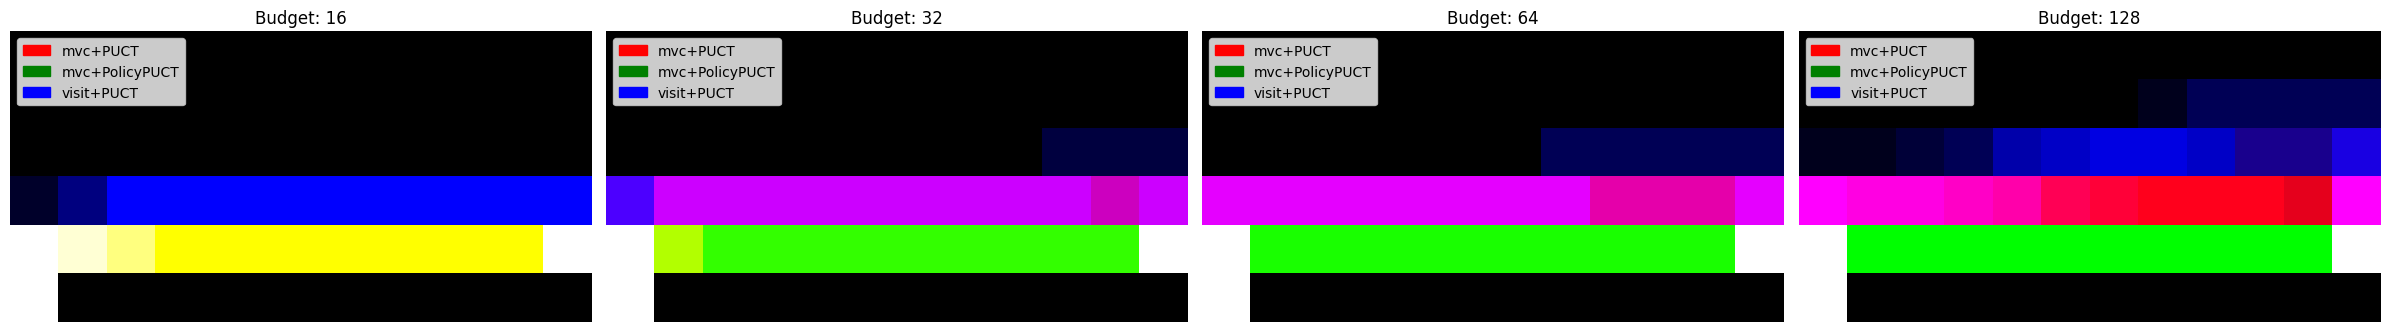

In [36]:
import matplotlib.patches as mpatches
grouped = df.groupby(['planning_budget', 'policy_combination'])['Evaluation/Trajectories'].sum()


# Determine the number of unique planning budgets
n_budgets = len(grouped.index.get_level_values(0).unique())

# Prepare a single figure with multiple subplots (one for each planning_budget)
fig, axs = plt.subplots(1, n_budgets, figsize=(6 * n_budgets, 6))

# Iterate over each planning_budget and create RGB heatmaps
for idx, (planning_budget, budget_group) in enumerate(grouped.groupby(level=0)):
    rgb_image = np.zeros((nrows, ncols, 3))  # Initialize RGB layers
    colors = ['Red', 'Green', 'Blue']  # Map trajos keys to RGB channels
    channel_colors = {name: color for name, color in zip(budget_group.index.get_level_values(1), colors)}

    # Compute density for each policy combination and assign to RGB channels
    for jdx, ((_, policy_combination), trajectories) in enumerate(budget_group.items()):
        density = calculate_density(trajectories, ncols, nrows) / len(trajectories)
        norm_density = density / np.max(density, where=(density!=0), initial=1)  # Normalize avoiding division by zero
        rgb_image[:, :, jdx % 3] += norm_density  # Accumulate in RGB layers, repeating colors if more than 3 policies

    ax = axs[idx] if n_budgets > 1 else axs
    ax.imshow(rgb_image, aspect='equal')
    ax.axis('off')  # Hide grid lines and labels

    # Create a legend
    legend_patches = [mpatches.Patch(color=color, label=name) for name, color in channel_colors.items()]
    ax.legend(handles=legend_patches, loc='upper left')
    ax.set_title(f"Budget: {planning_budget}")

plt.tight_layout()
plt.savefig("outfiles/dist_training_cliff_rgb.pdf")
plt.show()